(getting_started)=
# Getting Started


We're going to demonstrate how to estimate recruitment curves using a hierarchical Bayesian model and the rectified-logistic function.


## A Simple Example
```{eval-rst}
.. tip::

    If you have trouble running the commands in this tutorial, please copy the command
    and its output, then `open an issue <https://github.com/hbmep/hbmep/issues/new/choose>`_ on our GitHub repository. We'll do our best to help you!
```


Begin by reading the [mock_data.csv](https://raw.githubusercontent.com/hbmep/hbmep/docs-data/data/mock_data.csv) file:


In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/hbmep/hbmep/refs/heads/docs-data/data/mock_data.csv"
df = pd.read_csv(url)


In [2]:
print(f"df shape:\t\t{df.shape}")
print(f"df columns:\t\t{', '.join(df.columns.tolist())}")
print(f"All participants:\t{', '.join(df['participant'].unique().tolist())}")

n = 5
print(f"\nFirst {n} rows:\n\n{df.head(n=n).to_string()}")

df shape:		(245, 4)
df columns:		TMSIntensity, participant, PKPK_ECR, PKPK_FCR
All participants:	P1, P2, P3

First 5 rows:

   TMSIntensity participant  PKPK_ECR  PKPK_FCR
0         43.79          P1     0.197     0.048
1         55.00          P1     0.224     0.068
2         41.00          P1     0.112     0.110
3         43.00          P1     0.149     0.058
4         14.00          P1     0.014     0.011


This dataset contains TMS responses (peak-to-peak amplitude, in mV) for three participants (P1, P2, P3), recorded from two muscles (ECR and FCR). 
The column `TMSIntensity` represents stimulation intensity in percent maximum stimulator output (0–100% MSO).


## Build the model


(build-the-model)=
Next, we initialize a standard hierarchical Bayesian model. This step typically consists of assigning the model’s attributes to the appropriate dataframe columns, setting the sampling parameters, and choosing the recruitment curve function.


In [3]:
from hbmep.model.standard import HB

model = HB()

# Point to the respective columns in dataframe
model.intensity = "TMSIntensity"
model.features = ["participant"]
model.response = ["PKPK_ECR", "PKPK_FCR"]

# Specify the sampling parameters
model.mcmc_params = {
    "num_chains": 4,
    "thinning": 1,
    "num_warmup": 1000,
    "num_samples": 1000,
}

# Set the function
model._model = model.rectified_logistic


/home/vishu/repos/refactor/fix/hbmep/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Alternatively, these settings can be specified in an [hbmep.toml](https://github.com/hbmep/hbmep/blob/docs-data/configs/config.toml) configuration file without having to change the code directly. See {ref}`working-with-toml-configuration-files` for details.


## Running the model


Before fitting the model, we can visualize the dataset. Since the plot is saved as a PDF, we need to specify an output path.


In [4]:
import os

current_directory = os.getcwd()
output_path = os.path.join(current_directory, "dataset.pdf")

# Plot dataset and save it as a PDF
model.plot(df, output_path=output_path)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from hbmep.util import site, generate_response_colors

def plot(
    df,
    *,
    intensity,
    features,
    response,
    encoder=None,
    posterior=None,
    prediction_df=None,
    predictive=None
):

    df_features = df[features].apply(tuple, axis=1)
    combinations = sorted(df_features.unique().tolist())
    num_combinations = len(combinations)
    num_response = len(response)
    colors = generate_response_colors(num_response)

    nr, nc = num_combinations, num_response
    kr, kc = 1, 1
    heights = [1] * nr
    figsize = (6, 6)
    if prediction_df is not None:
        kr = 2
        heights = [1, .5] * nr
        figsize = (6, 8)
        pred_features = prediction_df[features].apply(tuple, axis=1)
        mu = predictive[site.mu]
        a = posterior[site.a]

    fig, axes = plt.subplots(
        *(nr * kr, nc * kc), figsize=figsize, constrained_layout=True,
        squeeze=False, sharex=True, height_ratios=heights
    )

    for i in range(num_combinations):
        combination = combinations[i]
        idx = df_features.isin([combination])
        curr_df = df[idx].reset_index(drop=True).copy()

        if prediction_df is not None:
            idx = pred_features.isin([combination])
            curr_pred = prediction_df[idx].reset_index(drop=True).copy()
            curr_mu = mu[:, idx]

        for j in range(num_response):
            ax = axes[i * kr, j * kc]
            x = curr_df[intensity]
            response_name = response[j]
            y = curr_df[response_name]
            sns.scatterplot(x=x, y=y, ax=ax, color=colors[j], s=25)
            ax.set_xlabel("")
            ax.set_ylabel("")
            # ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
            if not i:
                ax.set_title(response_name, fontsize=12)
            if not j:
                if encoder is None:
                    ax.set_ylabel(", ".join(combination), fontsize=12)
                else:
                    combination_inv = tuple(
                        encoder[features[0]].inverse_transform([u])[0]
                        for u in combination
                    )
                    ax.set_ylabel(f", ".join(combination_inv), fontsize=12)
            
            if prediction_df is not None:
                x = curr_pred[intensity]
                y = curr_mu[..., j].mean(axis=0)
                sns.lineplot(x=x, y=y, ax=ax, color=colors[j])

                ax = axes[i * kr + 1, j * kc]
                samples = a[:, *combination, j]
                sns.kdeplot(samples, color=colors[j], ax=ax)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.text(
                    0.02, 0.7, (*combination, j), fontsize=10,
                    va="bottom", ha="left", transform=ax.transAxes
                )
        
        miny, maxy = float('inf'), float('-inf')
        for j in range(num_response):
            ax = axes[i * kr, j * kc]
            lo, hi = ax.get_ylim()
            miny = min(miny, lo)
            maxy = max(maxy, hi)
            ax.sharey(axes[i * kr, 0])
        ax = axes[i * kr, 0]
        ax.set_ylim(miny, maxy)

    for i in range(nr):
        for j in range(nc):
            ax = axes[i * kr, j * kc]
            ax.spines[['right', 'top']].set_visible(False)
            ax.tick_params(axis="x", labelbottom=True)

            if prediction_df is not None:
                ax = axes[i * kr + 1, j * kc]
                ax.spines[['right', 'top']].set_visible(False)
                ax.tick_params(axis="both", left=False, labelbottom=True, labelleft=False)

    fig.align_xlabels()
    fig.align_ylabels()


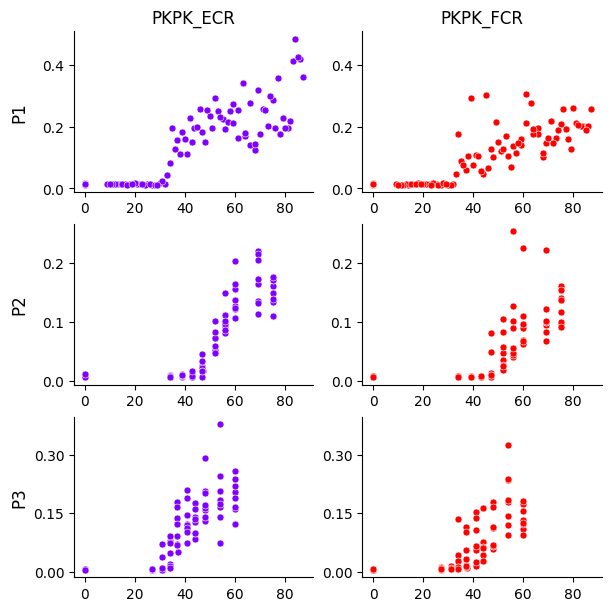

In [6]:
plot(df=df, **model.variables)


The plot shows rows as participants and columns as muscles. The x-axis is TMS intensity (% MSO), and the y-axis is MEP peak-to-peak amplitude (mV).


Next, we process the dataframe by encoding categorical feature columns. This returns the same dataframe with encoded values, plus an encoder dictionary for mapping back to original labels.


In [7]:
# Process the dataframe
df, encoder = model.load(df)


In [8]:
print(f"Encoded participants:\t{', '.join(map(str, df['participant'].unique().tolist()))}")

f = sorted(df[model.features[0]].unique().tolist())
finv = encoder[model.features[0]].inverse_transform(f)
f = map(str, f)
mapping = [" -> ".join(u) for u in list(zip(f, finv))]
print(f"Participant mapping:\t{', '.join(mapping)}")


Encoded participants:	0, 1, 2
Participant mapping:	0 -> P1, 1 -> P2, 2 -> P3


Now we run the model to estimate curves.


In [9]:
# Run
mcmc, posterior = model.run(df=df)

# Check convergence diagnostics
summary_df = model.summary(posterior)
print(summary_df.to_string())


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]





Running chain 0:   5%|▌         | 100/2000 [00:05<01:07, 28.04it/s]




Running chain 0:  10%|█         | 200/2000 [00:06<00:36, 49.70it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:07<00:24, 70.24it/s]


Running chain 0:  20%|██        | 400/2000 [00:07<00:17, 93.04it/s]





Running chain 0:  25%|██▌       | 500/2000 [00:08<00:13, 107.38it/s]



Running chain 0:  30%|███       | 600/2000 [00:09<00:11, 125.25it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:09<00:08, 146.29it/s]

Running chain 0:  45%|████▌     | 900/2000 [00:10<00:06, 182.06it/s]


Running chain 0:  50%|█████     | 1000/2000 [00:10<00:05, 192.61it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [00:11<00:04, 193.64it/s]


Running chain 0:  60%|██████    | 1200/2000 [00:11<00:04, 186.25it/s]


Running chain 0:  65%|██████▌   | 1300/2000 [00:12<00:03, 183.70it/s]


Running chain 0:  70

                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
a_loc         35.418  5.576    24.891     47.705      0.157    0.299    2321.0     869.0    1.0
a_scale       11.170  7.101     3.772     25.594      0.231    0.376    1611.0    1203.0    1.0
b_scale        0.189  0.115     0.061      0.381      0.003    0.013    1563.0    1594.0    1.0
g_scale        0.013  0.005     0.006      0.024      0.000    0.000    1047.0     975.0    1.0
h_scale        0.282  0.129     0.120      0.524      0.004    0.007    1054.0    1250.0    1.0
v_scale        4.547  2.913     0.246     10.230      0.050    0.040    2554.0    1966.0    1.0
c₁_scale       3.008  2.633     0.075      8.490      0.051    0.045    2077.0    2303.0    1.0
c₂_scale       0.280  0.102     0.125      0.493      0.003    0.003    1194.0    1728.0    1.0
a[0, 0]       31.900  0.463    30.731     32.637      0.016    0.021    1815.0     754.0    1.0
a[0, 1]       31.609  0.538    30.537   

## Visualizing the curves


Before plotting the curves, we have to generate predictions using the posterior.


In [10]:
# Create prediction dataframe
prediction_df = model.make_prediction_dataset(df=df, num_points=100)

# Use the model to predict on the prediction dataframe
predictive = model.predict(df=prediction_df, posterior=posterior)


This returns the posterior predictive distribution. We can use it to plot the estimated curves. Again, we specify the path where the generated PDF will be stored.


In [11]:
output_path = os.path.join(current_directory, "curves.pdf")

# Plot recruitment curves
model.plot_curves(
    df=df,
    prediction_df=prediction_df,
    predictive=predictive,
    posterior=posterior,
    encoder=encoder,
    output_path=output_path
)


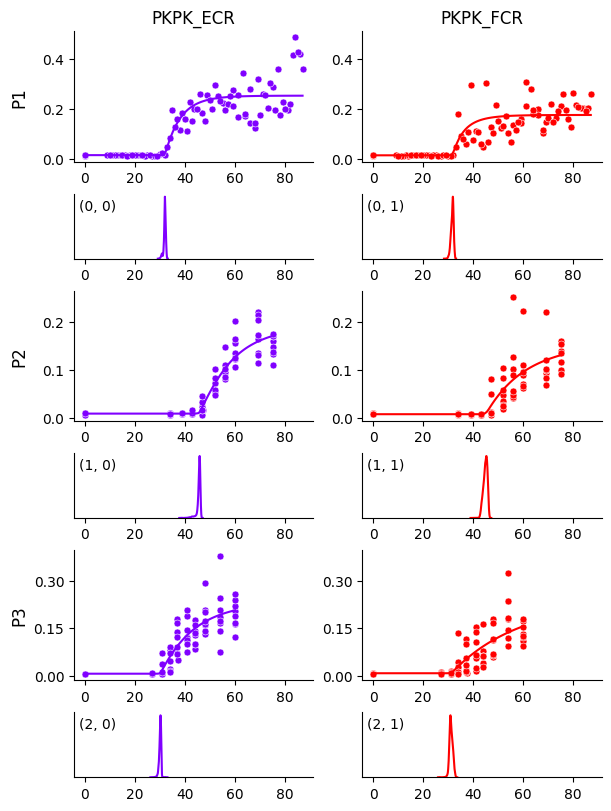

In [12]:
plot(df, **model.variables, encoder=encoder, posterior=posterior, prediction_df=prediction_df, predictive=predictive)


In each panel above, the top plot shows the estimated curve overlaid on data, and the bottom plot shows the posterior distribution of the threshold parameter.


## Mixture extension

The curves look good overall, except for participant P1 and muscle FCR, where the growth rate seems to be biased by a few data points. 
This can be addressed with a mixture model. To enable it, we can add the following line at the end of the [model-building code](build-the-model):

```python
# Enable mixture model
model.use_mixture = True


## Accessing parameters

Each participant, muscle combination is assigned a tuple index, which can be used to access the curve parameters, which are stored in the ``posterior`` dictionary as NumPy arrays. 
Here we show how to access the threshold parameter.


In [13]:
from hbmep.util import site

# Threshold parameter
a = posterior[site.a]


In [14]:
print(f"Shape of a:\t{a.shape}")
print(f"\nFirst dimension corresponds to the number of samples:\t\t{a.shape[0]}")
print(f"Second dimension corresponds to the number of participants:\t{a.shape[1]}")
print(f"Last dimension corresponds to the number of muscles:\t\t{a.shape[2]}")


Shape of a:	(4000, 3, 2)

First dimension corresponds to the number of samples:		4000
Second dimension corresponds to the number of participants:	3
Last dimension corresponds to the number of muscles:		2


By default, we have 4000 posterior samples (4 chains, 1000 samples each). We can set more chains or samples by updating the [model-building code](build-the-model):

```python
# Use 10 chains, 2000 samples each, for a total of 20,000 samples
model.mcmc_params = {
    "num_chains": 10,
    "thinning": 1,
    "num_warmup": 2000,
    "num_samples": 2000,
}


The other curve parameters can be accessed similarly using their keys.


In [15]:
print(f"{site.b} controlds the growth rate")
print(f"{site.g} is the offset")
print(f"({site.g} + {site.h}) is the saturation")


b controlds the growth rate
g is the offset
(g + h) is the saturation


## Saving the model

We can save the model, posterior samples, and other objects using pickle for later analysis.


In [16]:
import pickle

# Save the model
output_path = os.path.join(current_directory, "model.pkl")
with open(output_path, "wb") as f:
    pickle.dump((model,), f)
print(f"Saved model to {output_path}")

# Save the dataframe, encoder, and posterior samples
output_path = os.path.join(current_directory, "inference.pkl")
with open(output_path, "wb") as f:
    pickle.dump((df, encoder, posterior,), f)
print(f"Saved samples to {output_path}")

# Save the MCMC object
output_path = os.path.join(model.build_dir, "mcmc.pkl")
with open(output_path, "wb") as f:
    pickle.dump((mcmc,), f)
print(f"Saved MCMC object to {output_path}")


Saved model to /home/vishu/repos/refactor/fix/hbmep/docs/source/tutorials/model.pkl
Saved samples to /home/vishu/repos/refactor/fix/hbmep/docs/source/tutorials/inference.pkl
Saved MCMC object to mcmc.pkl


## Using other functions


Alternatively, we can use other functions to estimate the recruitment curves. The following choicej are available:

* logistic-4, also known as the Boltzmann sigmoid, is the most common function used to estimate recruitment curves
* logistic-5, is a more generalized version of logistic-4
* rectified-linear

If estimating threshold is not important, we recommend using logistic-5 over logistic-4, which has a much better predictive performance.


For example, to use logistic-5 function, we need to update the [model-building code](build-the-model) and point to it, and rest of the tutorial remains the same.

```python
# Set the function to logistic-5
model._model = model.logistic5
```